In [0]:
#upload the kaggle credentials

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santibermejo","key":"915ba36fd0bedf2b555bd9ddbb7bd0f5"}'}

In [0]:
#download data

!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c tgs-salt-identification-challenge

depths.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
 91% 148M/163M [00:01<00:00, 140MB/s]
100% 163M/163M [00:01<00:00, 157MB/s]
 87% 33.0M/37.9M [00:00<00:00, 60.1MB/s]
100% 37.9M/37.9M [00:00<00:00, 119MB/s] 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!unzip test.zip -d ~/test
!unzip train.zip -d ~/train

Archive:  test.zip
   creating: /root/test/images/
  inflating: /root/test/images/8cf16aa0f5.png  
  inflating: /root/test/images/23012be6b7.png  
  inflating: /root/test/images/9e46a3352e.png  
  inflating: /root/test/images/8016056c46.png  
  inflating: /root/test/images/a490a68472.png  
  inflating: /root/test/images/cf19041b8e.png  
  inflating: /root/test/images/a5c02f60cd.png  
  inflating: /root/test/images/631cec82b9.png  
  inflating: /root/test/images/bffa15aaa5.png  
  inflating: /root/test/images/31e17c9459.png  
  inflating: /root/test/images/b695427db8.png  
  inflating: /root/test/images/57b062d234.png  
  inflating: /root/test/images/1705ade299.png  
  inflating: /root/test/images/f1a3d6352e.png  
  inflating: /root/test/images/99e331e803.png  
  inflating: /root/test/images/d343f6974e.png  
  inflating: /root/test/images/068f7a5267.png  
  inflating: /root/test/images/d4c235a41e.png  
  inflating: /root/test/images/bf56f7dd40.png  
  inflating: /root/test/images/6b8b1e

In [0]:
train_df = pd.read_csv('train.csv')

In [0]:
def rle_decode(mask_rle, shape):
    if pd.isnull(mask_rle):
      img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    else:
      s = mask_rle.split()
      starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
      starts -= 1
      ends = starts + lengths
      img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
      for lo, hi in zip(starts, ends):
          img[lo:hi] = 1
    return img.reshape(shape)

In [0]:
from skimage.transform import resize

def decoded_mask(row):
  img = np.fliplr(np.rot90(rle_decode(row.rle_mask,(101,101)),k=3))
  formated_image = resize(img, (128,128), mode='constant', preserve_range=True)
  
  return np.array(formated_image).tolist()

In [0]:
from keras.preprocessing.image import load_img

def decoded_img(row):
  img = np.asarray(load_img(row.image, grayscale=True))
  formated_image = resize(img, (128,128), mode='constant', preserve_range=True)
  
  return (np.array(formated_image)/255).tolist()

In [0]:
train_df['mask_array'] = train_df.apply(decoded_mask, axis=1)
train_df.loc[:,'image'] = '/root/train/images/'+train_df['id']+'.png'
train_df['img_array'] = train_df.apply(decoded_img, axis=1)

In [0]:
train_df.head(3)

,id,rle_mask,mask_array,image,img_array
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/root/train/images/575d24d81d.png,"[[0.42048998066023285, 0.46287333170573675, 0...."
1,a266a2a9df,5051 5151,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/root/train/images/a266a2a9df.png,"[[0.27300468893612134, 0.3267752254710525, 0.3..."
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/root/train/images/75efad62c1.png,"[[0.4550078148935356, 0.44630641563266765, 0.3..."


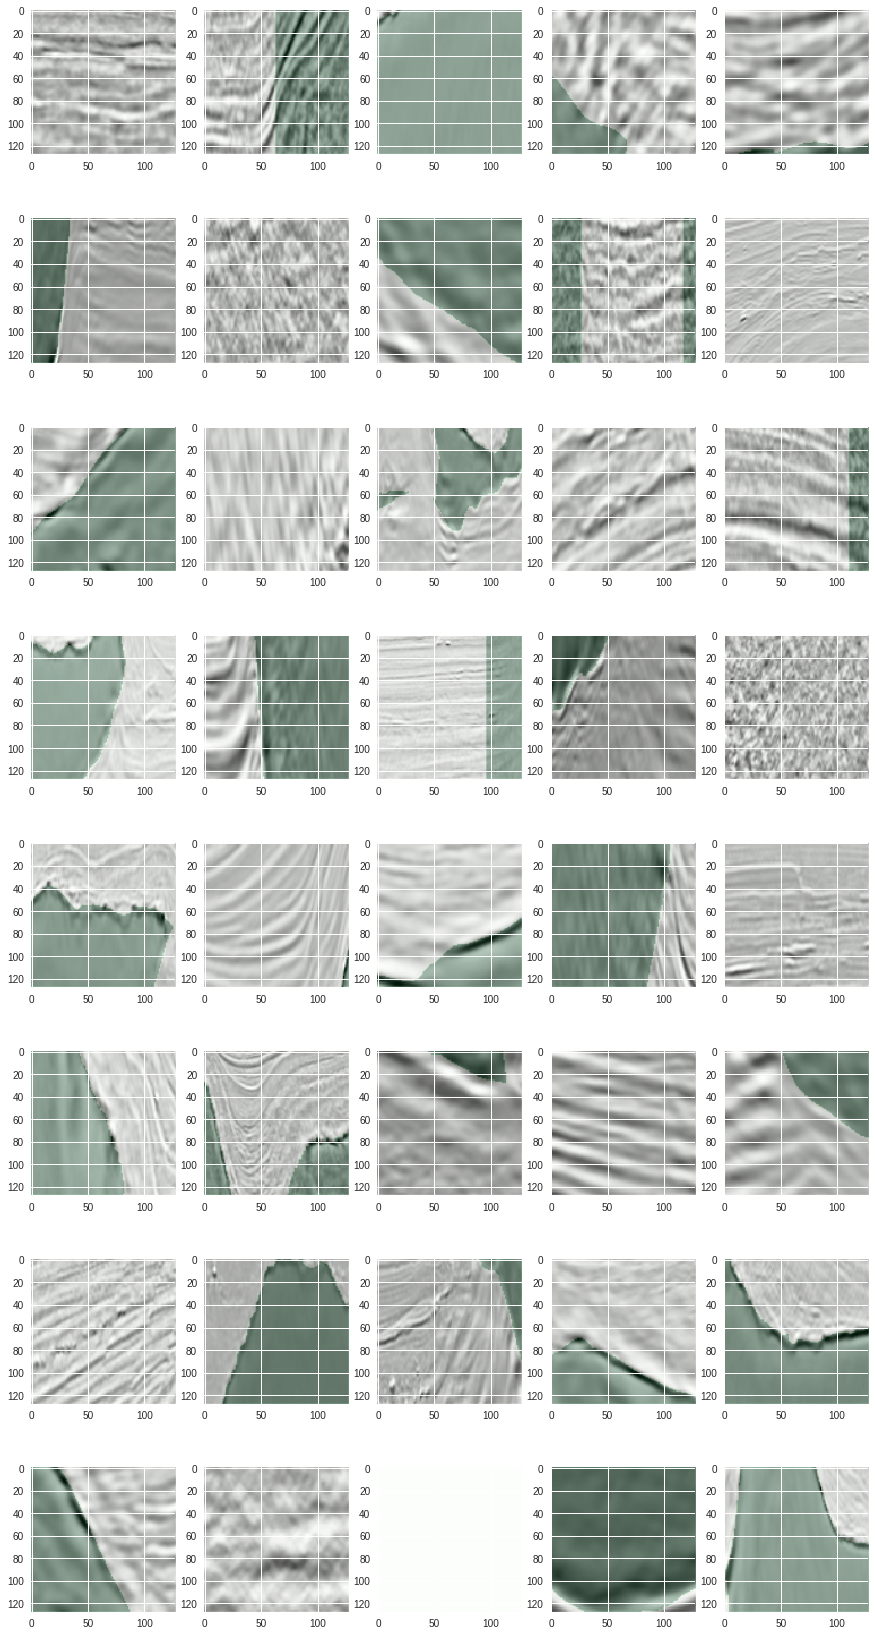

In [0]:
from pylab import imshow, show, get_cmap

f, axarray = plt.subplots(8,5,figsize=(15, 30))
for i in range(40):
    axarray[int(i/5),i%5].imshow(train_df['img_array'][i], cmap="Greys")
    axarray[int(i/5),i%5].imshow(train_df['mask_array'][i], alpha=0.3, cmap="Greens")

In [0]:
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras import Model

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [0]:
input_layer = Input((128,128,1))
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [0]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

X = np.asarray(list(map(lambda x: np.asarray(x), train_df['img_array']))).reshape(-1,128,128,1)
y = np.asarray(list(map(lambda x: np.asarray(x), train_df['mask_array']))).reshape(-1,128,128,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

epochs = 50
batch_size = 50
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

history = model.fit(X_train, 
                    y_train,
                    validation_data=[X_test, y_test], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 647s 202ms/step - loss: 0.5663 - acc: 0.7435 - val_loss: 0.4897 - val_acc: 0.7569

Epoch 00001: val_loss improved from inf to 0.48972, saving model to ./keras.model
Epoch 2/50
3200/3200 [==============================] - 645s 202ms/step - loss: 0.4839 - acc: 0.7460 - val_loss: 0.4411 - val_acc: 0.7569

Epoch 00002: val_loss improved from 0.48972 to 0.44107, saving model to ./keras.model
Epoch 3/50
3200/3200 [==============================] - 645s 202ms/step - loss: 0.4176 - acc: 0.8174 - val_loss: 0.4254 - val_acc: 0.8322

Epoch 00003: val_loss improved from 0.44107 to 0.42535, saving model to ./keras.model
Epoch 4/50
3200/3200 [==============================] - 647s 202ms/step - loss: 0.3917 - acc: 0.8327 - val_loss: 0.3480 - val_acc: 0.8542

Epoch 00004: val_loss improved from 0.42535 to 0.34803, saving model to ./keras.model
Epoch 5/50
3200/3200 [==============================] - 6

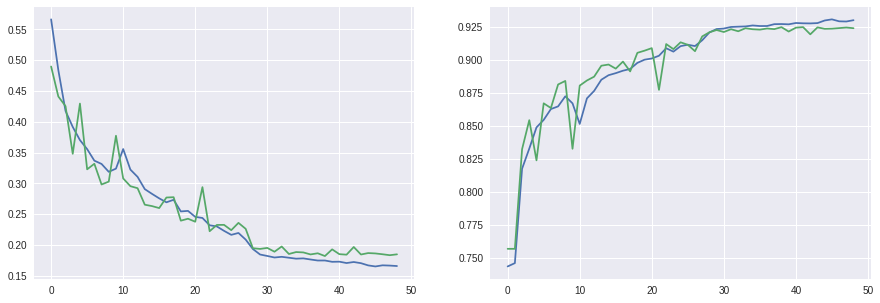

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [0]:
preds_valid = model.predict(X_test).reshape(-1, 128, 128)

In [0]:
y_test = y_test.reshape(-1,128,128)
y_test = list(map(lambda x: x.tolist(), y_test))

preds_valid = preds_valid.reshape(-1,128,128)
preds_valid = list(map(lambda x: x.tolist(), preds_valid))


Text(0.5,0.98,'Prediction vs Real')

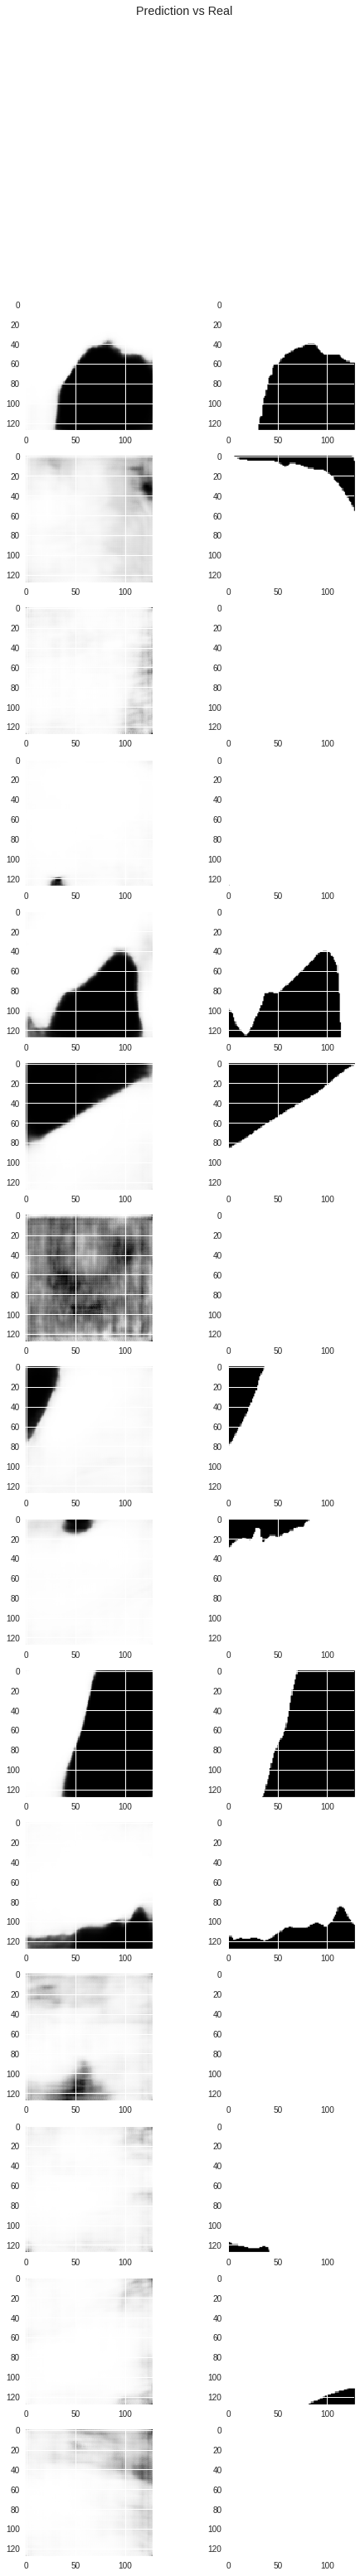

In [0]:
f, axarray = plt.subplots(15,2,figsize=(8, 50))
for i in range(15):
    axarray[i,0].imshow(preds_valid[i], cmap="Greys")
    axarray[i,1].imshow(y_test_2[i], cmap="Greys")
    
plt.suptitle("Prediction vs Real")